In [1]:
# Functions
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


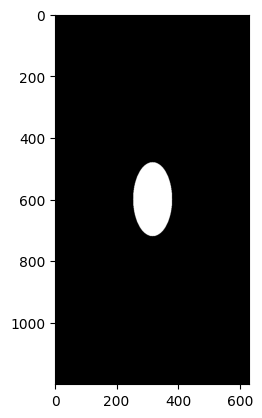

In [2]:
#Firt: import an image and create the Fourier Transfrom , obtain phase and amplitude

def import_tranform_image(file_path):

    """
    Function takes the image from a selected path and it returns the image, the image fourier tranfrom, the image phase and amplitude

    Parameters: 
        file_path (str): Path to the imput image
    Returns: 
        img (ndarray): Normalized grayscale of the imput image
        fft_img (ndarray): 2D Fourier Tranform of the image
        amplitude (ndarray): Magnitude spectrum of the Fourier Transform
        phase(ndarray): Phase Spectrum of the Fourier Tranform
    Notes:  
        The comments should give an overview of what eveythign does so fat in the code for an easily understanding

    """

    #Import image as grayscale and normalized it to values ranging from 0 to 1 
    img = np.array(Image.open(file_path).convert('L')).astype('float32') / 255.0
    # Take the fouerier tranform of the image  np.fft.fft2 > takes the FT of the image and np.fft.fftshif, shifts the 0 to be in 
    # the center bettwe for practice inside the image processing community
    fft_img = np.fft.fftshift(np.fft.fft2(img))
    # take image amplitude and phase
    amplitude = np.abs(fft_img)
    phase = np.angle(fft_img)
    return img, fft_img, amplitude, phase


file_name = "C:/Users/Irene/Documents/AA UNI/02_Master/02_Semester/Innovation_methods_in_photonics/LW_image_fouier.jpg"
img, fft_img, amplitude, phase = import_tranform_image(file_name)



def image_illumination(number_LED_x, number_LED_y, distances_LED, distance_sample):

    """
    Function takes the an arbitrary number of LEDs in the x direction an arbitrary number of LED in the y direction, 
    the ditances between the LEDs (ussually given by the manufacturer) and the ditance form the sample to the LEDs

    Parameters: 
        number_LED_x (int):  number of LEDs in the x direction user needs to take into account that python starts with 0 as the number counter
        number_LED_y (int):  nuumber of LEDs in the y direction user needs to take into account that python starts with 0 as the number counter
        distances_LED (int): distance between LEDs the programm work such as the input needs to be in mm
        distances_sample (int): distance between LEDs and the sample the programm work such as the input needs to be in mm

    Returns: 
        LED_positions (ndaraay): gives the positon of the LEDs in the real space
        LED_positions_K_space(ndarray): gives the position of the LEDs in the fourier space
    Notes:  
        The comments should give an overview of what eveythign does so fat in the code for an easily understanding

    """
    # initialization of both of the arrays of the LEDs:
    LED_positions = []
    LED_positions_K_space = []

    # Most of the LED positions are given in mm convert to meters
    distances_LED = distances_LED /1000
    distance_sample = distance_sample/1000

    # Lets create the LED grid in real space and center it around 0,0:
    # how does this work ? > Lets say 3x3 LED panel > number_LED_x -1 calculates the sapce between the Leds in this case 2 and then divides to get teh center
    # and then multiplies by the -distances of the LED sample so we can get the top right corner for both the x and y direction 
    start_x = -((number_LED_x -1) / 2) * distances_LED
    start_y = -((number_LED_y -1) / 2) * distances_LED

    # we iterate over all the amount of LEDs to get the position of the LEDs in x and y direction to get positon in real and k-space
    for i in range (number_LED_x):
        for j in range (number_LED_y):
            # Getting positions in real space start lets say was -0.4 then for eevry iteration we will have -0.4, -0.4+ 0.4, -0.4+0.8 and same with the y position
            x_positions = start_x + i * distances_LED
            y_positions = start_y + j * distances_LED

            # storing our positons in the list
            LED_positions.append([x_positions, y_positions])

            # now we have to map the 2D positions into the K-space, as we look for directions we take the normalization of the vectors being normalized, this 
            # normalization is done with the 3D pythagoras theorem 
            distance = np.sqrt(x_positions**2 + y_positions**2+ distance_sample**2)
            kx = x_positions/ distance
            ky = y_positions / distance

            # store the values into the list
            LED_positions_K_space.append([kx, ky])
    # convert our list into a array
    LED_positions = np.array(LED_positions)
    LED_positions_K_space = np.array(LED_positions_K_space)
    return LED_positions, LED_positions_K_space

LED_positions, LED_positions_K_space = image_illumination(2, 2, 4, 80)

def pupil_function(img, NA, wavelength, pixel_size):

    """
    This function will create a cicrcular mask which determines the maximun number of frequencies that our filter 
    lets through, as it acts as a low pass filter.mro

    Inputs:
        img (np.array): contains all the infromaiton about our image 
        NA (float): Numerical aperture of the objective of use
        wavelength (int): wavelegth of light use should be given in m
        pixel_size (float): pixxel size of the LED panel shoudld be given in mm

    Output:
        pupil (ndarray): A binary boolean 2D array in k-space. The frequencies inside
        are marked by 1 and the ourside are marked by 0.

    """

    # First thing first we have to obtain the width and the height of our image 
    width, heigth = img.shape
    # Convert pixel size to meters
    pixel_size = pixel_size /1000

    # Get the Frequency components of the images, the pixel size is so we can easily map the
    # real pixel sixe into the fourier space. 
    fx = np.fft.fftfreq(width, d=pixel_size)
    fy = np.fft.fftfreq(heigth, d=pixel_size)

    # SHifting the frequencies to the ceneter and creating the 2D array as images are in 2D
    # fourier space and you need an x and y position to be usefull for calculation
    FX, FY = np.meshgrid(np.fft.fftshift(fx), np.fft.fftshift(fy))

    # Sampling theorem for the frequencies that are allow, then we have that frequencies
    # smaller than those will be able to pass through
    f_cutoff = NA / wavelength
    pupil = (FX**2 + FY**2) <= f_cutoff**2
    return pupil.astype(np.float32)


pupil = pupil_function(img, 0.5, 500e-9, 1e-4)
plt.imshow(pupil, cmap='gray')
plt.show()